In [1]:
import cv2,glob,os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
impath=r'C:\Users\HARGUN\OneDrive\Desktop\rcnn\RCNN-master\imgs\Images'
anotpath=r'C:\Users\HARGUN\OneDrive\Desktop\rcnn\RCNN-master\anot\Airplanes_Annotations'

In [3]:
s_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

425


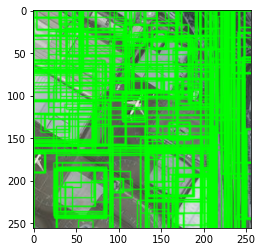

In [4]:
im = cv2.imread(os.path.join(impath,"42850.jpg"))
s_search.setBaseImage(im)
s_search.switchToSelectiveSearchFast()
rects = s_search.process()
print(len(rects))
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

In [5]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [6]:
#preprocessing the csv files
newanotpath=r'C:\Users\HARGUN\OneDrive\Desktop\rcnn\RCNN-master\anotprocessesed'
for k in glob.glob(anotpath +'//'+'*'):
    dfnew=pd.DataFrame(columns=[0,1,2,3])
    if(k[-16:].split('_')[0]=='airplane'):
        df=pd.read_csv(k)
        count=0
        for i in range(int(df.columns[0])):

            
            listvals=[]
            xywh=str(df.iloc[i])
            for j in xywh.split('\n')[0].split(' '):
            
                if(j!='' and j!=xywh.split('\n')[0].split(' ')[0]):
                    listvals.append(j)
                
            for l in range(len(listvals)):
                dfnew.loc[count,l]=listvals[l]
            count=count+1
        
        dfnew.to_csv(newanotpath+'\\'+k[-16:])


In [7]:
glob.glob(r'C:\Users\HARGUN\OneDrive\Desktop\rcnn\RCNN-master\anotprocessesed'+'\\'+'*')

['C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_001.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_002.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_003.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_004.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_005.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_006.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_007.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_008.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_009.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_010.csv',
 'C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN

In [8]:
imcsv=pd.read_csv('C:\\Users\\HARGUN\\OneDrive\\Desktop\\rcnn\\RCNN-master\\anotprocessesed\\airplane_001.csv')

In [9]:
imcsv

,Unnamed: 0,0,1,2,3
0,0,173,15,232,70
1,1,49,76,139,153
2,2,4,164,93,244


In [10]:
imcsv['0'][1]

49

In [11]:
img=cv2.imread(r'C:\Users\HARGUN\OneDrive\Desktop\rcnn\RCNN-master\imgs\Images' + '\\' 'airplane_001.jpg')

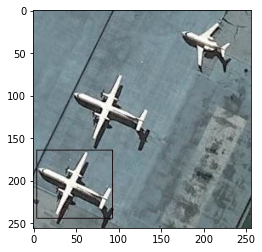

In [12]:
plt.imshow(cv2.rectangle(img,(4,164),(93,244),cv2.LINE_AA))

In [13]:
train_images=[]
train_labels=[]
x=0
for i in glob.glob(r"C:\Users\HARGUN\OneDrive\Desktop\rcnn\RCNN-master\anotprocessesed\*"):
#     impath +'\\'+i[-16:-4]+'.jpg'
    try:
        gtvalues=[]
        x=pd.read_csv(i)
        image=cv2.imread(impath +'\\'+i[-16:-4]+'.jpg')
        gtvalues.append({"x1":x['0'][0],"y1":x['1'][0],"x2":x['2'][0],"y2":x['3'][0]})
        s_search.setBaseImage(image) 
        s_search.switchToSelectiveSearchFast() 
        ssresults = s_search.process() 
        imout = image.copy()  
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0: 
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h}) 
                    if counter < 30:    
                        if iou > 0.70: 
                            timage = imout[x:x+w,y:y+h]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1              
                    if falsecounter <30:      
                        if iou < 0.3:       
                            timage = imout[x:x+w,y:y+h]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1            
                if fflag == 1 and bflag == 1:  
                    print("inside")
                    flag = 1 
    except Exception as e:
        print(e)
        print("error in "+i[-16:])
        continue
# gtvalues


error in airplane_053.csv
inside

error in airplane_096.csv

error in airplane_182.csv

error in airplane_219.csv

error in airplane_293.csv

error in airplane_326.csv

error in airplane_332.csv

error in airplane_337.csv
index 0 is out of bounds for axis 0 with size 0
error in airplane_375.csv
inside

error in airplane_408.csv

error in airplane_646.csv
index 0 is out of bounds for axis 0 with size 0
error in airplane_667.csv


In [14]:
train_labels

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


In [15]:
# conversion of train data into arrays for further training
X_new = np.array(train_images)
Y_new = np.array(train_labels)


In [16]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers

In [17]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
    layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [22]:
model.summary()
model.fit(X_new,Y_new,batch_size = 64,epochs = 10, verbose = 1,validation_split=0.2,shuffle = True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
model.save(r'C:\Users\HARGUN\OneDrive\Desktop\rcnn\RCNN-master\model_detector.h5')

In [22]:
svm_image = [];
svm_label = [];

In [23]:
for i in glob.glob(r"C:\Users\HARGUN\OneDrive\Desktop\rcnn\RCNN-master\anotprocessesed\*"):
#     impath +'\\'+i[-16:-4]+'.jpg'
    try:
        gtvalues=[]
        x=pd.read_csv(i)
        image=cv2.imread(impath +'\\'+i[-16:-4]+'.jpg')
        gtvalues.append({"x1":x['0'][0],"y1":x['1'][0],"x2":x['2'][0],"y2":x['3'][0]})
        s_search.setBaseImage(image) 
        s_search.switchToSelectiveSearchFast() 
        ssresults = s_search.process() 
        imout = image.copy()  
        counter = 0
        falsecounter = 0
        flag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if falsecounter <5:
                        if iou < 0.3:
                            timage = imout[x:x+w,y:y+h]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            svm_image.append(resized)
                            svm_label.append([1,0])
                            falsecounter += 1
                    else :
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+ i[-16:])
        continue


error in airplane_053.csv

error in airplane_096.csv

error in airplane_182.csv

error in airplane_219.csv

error in airplane_293.csv

error in airplane_326.csv

error in airplane_332.csv

error in airplane_337.csv
index 0 is out of bounds for axis 0 with size 0
error in airplane_375.csv

error in airplane_408.csv

error in airplane_646.csv
index 0 is out of bounds for axis 0 with size 0
error in airplane_667.csv


In [46]:
x =model.get_layer('fc2').output
Y = tf.keras.layers.Dense(2,activation="softmax")(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [47]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 5,verbose = 1,shuffle = True,validation_split = 0.2)

Epoch 1/5
76/76 [==============================] - 1101s 15s/step - loss: 1.5056e-05 - accuracy: 1.0000 - val_loss: 9.3389e-12 - val_accuracy: 1.0000
Epoch 2/5
76/76 [==============================] - 1119s 15s/step - loss: 2.7879e-12 - accuracy: 1.0000 - val_loss: 8.2876e-12 - val_accuracy: 1.0000
Epoch 3/5
76/76 [==============================] - 1149s 15s/step - loss: 2.1990e-12 - accuracy: 1.0000 - val_loss: 7.2946e-12 - val_accuracy: 1.0000
Epoch 4/5
76/76 [==============================] - 1192s 16s/step - loss: 1.8769e-12 - accuracy: 1.0000 - val_loss: 6.4628e-12 - val_accuracy: 1.0000
Epoch 5/5
76/76 [==============================] - 1149s 15s/step - loss: 2.0463e-12 - accuracy: 1.0000 - val_loss: 5.6890e-12 - val_accuracy: 1.0000


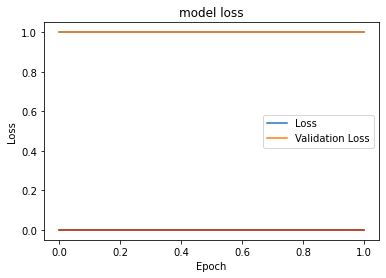

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
plt.plot(hist_final.history["accuracy"])
plt.plot(hist_final.history['val_accuracy'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

0 [[1.9826603e-06]]
1 [[0.00044239]]
2 [[0.00116834]]
3 [[3.9022186e-08]]
4 [[7.674843e-09]]
5 [[4.354604e-05]]
6 [[0.00040975]]
7 [[5.469423e-11]]
8 [[0.00114062]]
9 [[7.420065e-05]]
10 [[0.00166214]]
11 [[6.4836725e-12]]
12 [[1.6556541e-15]]
13 [[0.0006372]]
14 [[8.788914e-10]]
15 [[0.00585076]]
16 [[1.7763282e-08]]
17 [[1.1054647e-05]]
18 [[0.00139344]]
19 [[0.07761878]]
20 [[7.1057934e-12]]
21 [[3.979381e-06]]
22 [[1.7510193e-07]]
23 [[1.7703539e-13]]
24 [[5.093047e-15]]
25 [[1.324658e-23]]
26 [[4.713967e-05]]
27 [[7.2389164e-05]]
28 [[8.2078526e-07]]
29 [[2.4245749e-06]]
30 [[6.375224e-05]]
31 [[3.509513e-05]]
32 [[1.098674e-09]]
33 [[0.00121531]]
34 [[1.3335588e-06]]
35 [[5.661617e-07]]
36 [[0.00023225]]
37 [[0.00017539]]
38 [[4.3940563e-12]]
39 [[0.00059348]]
40 [[1.6282715e-06]]
41 [[1.1046443e-06]]
42 [[7.632519e-10]]
43 [[0.0001564]]
44 [[1.9900117e-12]]
45 [[3.0070408e-14]]
46 [[1.1431075e-16]]
47 [[0.00026703]]
48 [[3.4737092e-17]]
49 [[6.507793e-05]]
50 [[0.00019759]]
51 [

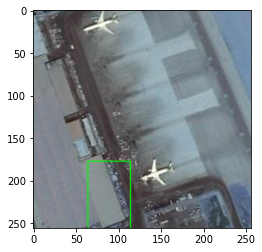

In [29]:
image = cv2.imread(impath+'//'+'airplane_022.jpg')
s_search.setBaseImage(image)
s_search.switchToSelectiveSearchFast()
ssresults = s_search.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[x:x+w,y:y+h]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        resized = np.expand_dims(resized,axis = 0)
        out = model.predict(resized)
        print(e,out)
    if(out[0][0]>0.55):
        boxes.append([x,y,w,h])
        count+=1

for box in boxes:
    x, y, w, h = box
    print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [45]:
boxes

[[60, 96, 111, 66], [175, 133, 46, 29], [175, 137, 51, 39]]

In [51]:
x['1'][0]

75

In [ ]:
x1=x['0']
    y1=x['1']
    x2=x['2']
    y2":x['3']